# CYPLAN255
### Urban Informatics and Visualization

HIT RECORD and TRANSCRIBE

# Lecture 14 -- Geospatial Data Analysis
******
March 14, 2022

<img src="https://s3-eu-west-1.amazonaws.com/ngs-mw-prod/9/97/11799/11799.jpg" width=500 align='right' title='Alfred G Buckham, Aerial View of Edinburgh (c. 1920)'>

# Agenda
1. Announcements
2. Final projects
3. An example
4. More Geopandas
5. Summary
6. For next time
7. Questions


# 1. Announcements

- Guest lecture on Wednesday (Irene!)
- Still holding drop-in office hours today (remote)
- Final project groups [sign-up sheet](https://docs.google.com/spreadsheets/d/1j9QWr_izCnWX48Q_AM0pzyap-sHCAuRMnJDqQNJJ9xs/edit?usp=sharing)

# 2. Final Projects

In [1]:
from IPython.display import IFrame
IFrame("../misc/final_project_description.pdf", width="100%", height=700)

# 3. An example

**Historical Redlining Is Associated with Present-Day Air Pollution Disparities in U.S. Cities**[<sup id="fn1-back">1</sup>](#fn1)

<img src="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/estlcu/0/estlcu.ahead-of-print/acs.estlett.1c01012/20220301/images/large/ez1c01012_0003.jpeg" width=700>

Two open data sets:
  - Census Block-level air pollution data available from [CACES](https://www.caces.us/data)
  - Redlining data available from https://dsl.richmond.edu/panorama/redlining/

[<sup id="fn1">1</sup>](#fn1-back) Lane, H. M., Morello-Frosch, R., Marshall, J. D., & Apte, J. S. (n.d.).  Environmental Science & Technology Letters, 0(0), null. https://doi.org/10.1021/acs.estlett.1c01012

In [2]:
%%html
<iframe src="https://dsl.richmond.edu/panorama/redlining/" width=100% height=700>

**Question**

- Correlation or causation?

- How might we inch our way towards causation?

# 4. More GeoPandas - Berkeley Edition

For this exercise we're going to download the Census Block geometries for the City of Berkeley:

In [28]:
import geopandas as gpd
blocks = gpd.read_file("https://data.cityofberkeley.info/api/geospatial/caxd-afre?method=export&format=Shapefile")

<AxesSubplot:>

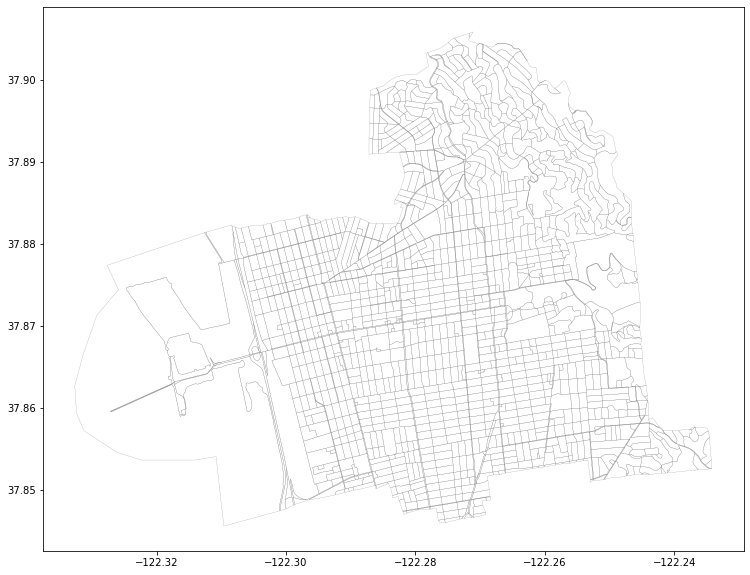

In [29]:
blocks.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(14,10))

## 4.1 Our First Geoprocessing Step: Dissolve

Let's say we want to create a census tract dataset from the census block one, which we can see from inspecting the data above, contains a column called tractce10, for 2010 census tracts.  We can verify it by looking more closely at the geoid10 field, which appears to be a FIPS code.

Geoprocessing steps like dissolve do geometric processing on the geometry column of a GeoSeries or GeoDataFrame (which contains a GeoSeries column).

In [30]:
blocks.head()

,aland10,awater10,blockce10,countyfp10,geoid10,intptlat10,intptlon10,mtfcc10,name10,statefp10,tractce10,geometry
0,10537.0,0.0,2005,001,060014225002005,+37.8760481,-122.2564001,G5040,Block 2005,06,422500,"POLYGON ((-122.25593 37.87658, -122.25588 37.8..."
1,11761.0,0.0,3001,001,060014228003001,+37.8677659,-122.2630010,G5040,Block 3001,06,422800,"POLYGON ((-122.26232 37.86739, -122.26311 37.8..."
2,10506.0,0.0,3008,001,060014228003008,+37.8658164,-122.2638664,G5040,Block 3008,06,422800,"POLYGON ((-122.26319 37.86544, -122.26343 37.8..."
3,19893.0,0.0,3009,001,060014236023009,+37.8621680,-122.2636773,G5040,Block 3009,06,423602,"POLYGON ((-122.26312 37.86270, -122.26310 37.8..."
4,21110.0,0.0,2000,001,060014228002000,+37.8681223,-122.2602461,G5040,Block 2000,06,422800,"POLYGON ((-122.26095 37.86850, -122.25965 37.8..."


<AxesSubplot:>

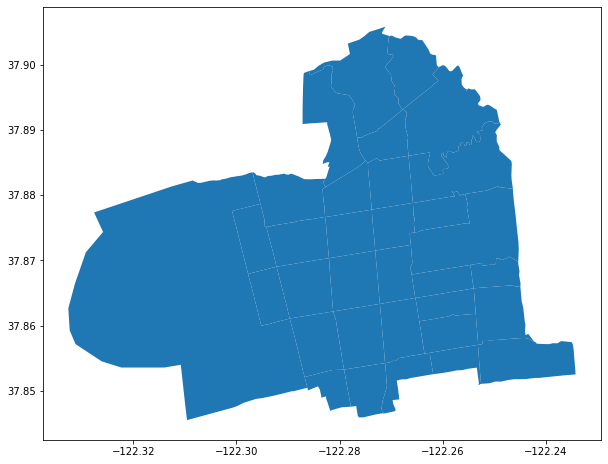

In [31]:
tracts = blocks.dissolve(by='tractce10')
tracts.plot(figsize=(10,8))

## 4.2 Setting the crs of GeoDataFrames

Let's see what the crs is for the newly created dataset, and what it's type is.

In [32]:
print(tracts.crs)
print(type(tracts))

GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
<class 'geopandas.geodataframe.GeoDataFrame'>


OK, so dissolve created a new GeoDataFrame, and assigned it the same crs as the original GeoDataFrame. But just to be sure you know how to do this in the event you load a file and the crs is undefined, we will set the crs in order to do other spatial operations on the tract dataset. 

In [33]:
tracts.crs = {'init' :'epsg:4326'}
# or alternatively:
tracts.crs = blocks.crs
print(tracts.crs)

GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## 4.3. Loading 311 Cases for Grafitti and Vandalism as Point Data

Let's load 311 data for graffiti and vandalism, dropping rows that have missing data (a good fraction of the data seem to be missing latitude and longitude)

In [34]:
import pandas as pd
vandalism = pd.read_json("https://data.cityofberkeley.info/resource/bscu-qpbu.json?request_category=Graffiti%20and%20Vandalism&$limit=20000")

In [35]:
vandalism.head()

,case_id,date_opened,case_status,date_closed,request_category,request_subcategory,request_detail,object_type,apn,street_address,city,state,neighborhood,latitude,longitude,location
0,121000736071,2019-12-06T16:26:00.000,Closed,2019-12-11T14:53:00.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Traffic Maintenance,Property,058 211901900,825 DELAWARE ST,Berkeley,CA,Berkeley,37.870858,-122.298280,"{'latitude': '37.87085808', 'longitude': '-122..."
1,121000654949,2019-01-14T08:15:00.000,Closed,2019-01-17T07:46:37.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Streets and Utilities,Individual,NaN,NaN,Berkeley,CA,Berkeley,NaN,NaN,NaN
2,121000751363,2020-02-16T17:04:00.000,Closed,2020-02-23T13:13:00.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Streets and Utilities,Property,NaN,"Intersection of Mabel and Ashby, BERKELEY, CA",Berkeley,CA,Berkeley,NaN,NaN,NaN
3,121000420275,2018-09-05T17:37:00.000,Closed,2019-07-31T12:19:06.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Individual,NaN,NaN,Berkeley,CA,Berkeley,NaN,NaN,NaN
4,121000721153,2019-10-05T14:33:00.000,Closed,2019-10-08T15:02:00.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Streets and Utilities,Property,057 208901401,1007 UNIVERSITY AVE,Berkeley,CA,Berkeley,37.869009,-122.294015,"{'latitude': '37.86900911', 'longitude': '-122..."


We loaded a csv into a standard pandas DataFrame.  But it contains Latitude, Longitude columns, so with a couple of additional steps we can turn this into a GeoDataFrame, and set its crs.

Study this example carefully. It is very common to encounter spatial data in a tabular form that you'll want to quickly turn into a geometry data types.  Note the use of the built-in `zip()` function within a list comprehension to pull the Latitude and Longitude columns together to define each Point geometry.

In [36]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(vandalism.longitude, vandalism.latitude)]
geovandalism = gpd.GeoDataFrame(vandalism, crs='epsg:4326', geometry=geometry)
geovandalism.head()

,case_id,date_opened,case_status,date_closed,request_category,request_subcategory,request_detail,object_type,apn,street_address,city,state,neighborhood,latitude,longitude,location,geometry
0,121000736071,2019-12-06T16:26:00.000,Closed,2019-12-11T14:53:00.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Traffic Maintenance,Property,058 211901900,825 DELAWARE ST,Berkeley,CA,Berkeley,37.870858,-122.298280,"{'latitude': '37.87085808', 'longitude': '-122...",POINT (-122.29828 37.87086)
1,121000654949,2019-01-14T08:15:00.000,Closed,2019-01-17T07:46:37.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Streets and Utilities,Individual,NaN,NaN,Berkeley,CA,Berkeley,NaN,NaN,NaN,POINT EMPTY
2,121000751363,2020-02-16T17:04:00.000,Closed,2020-02-23T13:13:00.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Streets and Utilities,Property,NaN,"Intersection of Mabel and Ashby, BERKELEY, CA",Berkeley,CA,Berkeley,NaN,NaN,NaN,POINT EMPTY
3,121000420275,2018-09-05T17:37:00.000,Closed,2019-07-31T12:19:06.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Individual,NaN,NaN,Berkeley,CA,Berkeley,NaN,NaN,NaN,POINT EMPTY
4,121000721153,2019-10-05T14:33:00.000,Closed,2019-10-08T15:02:00.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Streets and Utilities,Property,057 208901401,1007 UNIVERSITY AVE,Berkeley,CA,Berkeley,37.869009,-122.294015,"{'latitude': '37.86900911', 'longitude': '-122...",POINT (-122.29401 37.86901)


## 4.4. Mapping With Layers

Let's see what we have:

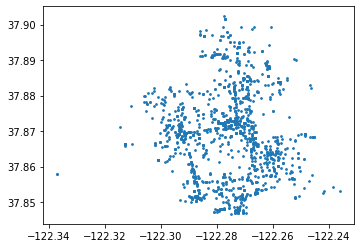

In [37]:
geovandalism.plot(markersize=3);

A bunch of points mapped in isolation is not very informative, since it lacks context.  Let's add the points to the block base to add visual context. Note the use of Matplotlib syntax to set the parameters we want for the figure.

In [38]:
import pyplot as plt
fig, ax = plt.subplots(figsize=(18,10))
blocks.plot(color='white', edgecolor='black', linewidth=.1, ax=ax)
geovandalism.plot(markersize=4, ax=ax)
ax.set_title('Vandalism in Berkeley')
ax.set_axis_off()

ModuleNotFoundError: No module named 'pyplot'

## 4.5 Projecting to a Different crs

So far our data has been in world coordinates (sometimes referred to as geographic cordinates). This works fine for some purposes like generating basic maps, other than the fact that the maps can appear distorted at different scales because we are squashing a spherical coordinate system onto a flat image. But there is a more fundamental issue: distances measured on a spherical coordinate system will be incorrect for point to point distance measurements we often want to do in urban data analysis.  Since we will be doing some spatial analysis on these data, we need to project them to a coordinate system that allows more meaningful measurements of distance. We'll use a standard Bay Area CRS for this purpose: EPSG:26910. You can find out more about this CRS [here](http://spatialreference.org/ref/sr-org/6787/)

In [16]:
geovandalism_proj = geovandalism.to_crs("epsg:26910")
blocks_proj = blocks.to_crs("epsg:26910")
tracts_proj = tracts.to_crs("epsg:26910")
tracts_proj.crs

<Derived Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Let's check the bounds for the whole dataset to see what kind of coordinates we're working with:

In [17]:
bounds = tracts_proj.total_bounds
print(bounds)

[ 558702.20665035 4188902.46468913  567371.41840041 4195616.51058903]


## 4.6 Spatial Join: Intersect

A very common geoprocessing operation is to do a **point-in-polygon** assignment using an intersection of the geometries of points and polygons.  It is like a normal merge, where the two datasets do not have a common key to merge on, but instead these tables have coordinates that enable geometric processing to find matching rows.

GeoPandas makes this pretty easy using a spatial join, or `gpd.sjoin()` function with the `intersects` operation argument.

In [19]:
geovandalism_proj_blocks = gpd.sjoin(geovandalism_proj, blocks_proj, how="inner", op='intersects')
geovandalism_proj_blocks.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,case_id,date_opened,case_status,date_closed,request_category,request_subcategory,request_detail,object_type,apn,street_address,...,awater10,blockce10,countyfp10,geoid10,intptlat10,intptlon10,mtfcc10,name10,statefp10,tractce10
0,121000736071,2019-12-06T16:26:00.000,Closed,2019-12-11T14:53:00.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Traffic Maintenance,Property,058 211901900,825 DELAWARE ST,...,0.0,2008,001,060014221002008,+37.8715730,-122.2982813,G5040,Block 2008,06,422100
3480,121000833020,2021-03-04T11:43:00.000,Open,NaN,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Streets and Utilities,Property,058 211901100,1720 SEVENTH ST,...,0.0,2008,001,060014221002008,+37.8715730,-122.2982813,G5040,Block 2008,06,422100
3502,121000884098,2021-10-15T08:29:00.000,Open,NaN,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Streets and Utilities,Property,058 211901300,1728 SEVENTH ST,...,0.0,2008,001,060014221002008,+37.8715730,-122.2982813,G5040,Block 2008,06,422100
3639,121000893215,2021-11-24T16:40:00.000,Closed,2022-03-04T10:07:00.000,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Code Enforcement,Property,058 211901500,1732 SEVENTH ST,...,0.0,2008,001,060014221002008,+37.8715730,-122.2982813,G5040,Block 2008,06,422100
3740,121000894462,2021-12-02T07:25:00.000,Open,NaN,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Parks,Property,058 211901500,1732 SEVENTH ST,...,0.0,2008,001,060014221002008,+37.8715730,-122.2982813,G5040,Block 2008,06,422100


Now we know the Census Block ID of each record in the vandalism data!

## 4.7 Aggregating data using Groupby

Let's say we want to look at the incidence of vandalism events at some level of geography like neighborhood or census tract rather than just looking at the raw data.  We can use groupby operations to get the counts of events within each geographic area, then merge it on to a Geodataframe to visualize it.

We use a reset_index to create a unique index and make the groupby column become a column in the resulting dataframe instead of the index. That makes the merge a bit clearer.

In [20]:
tract_v = geovandalism_proj_blocks.groupby('tractce10')['case_id'].count().to_frame(name='total_vandalism').reset_index()
tract_v.head()

,tractce10,total_vandalism
0,421100,2
1,421200,71
2,421300,50
3,421400,16
4,421500,53


In [21]:
tracts2 = pd.merge(tracts_proj,tract_v, left_index=True, right_on='tractce10')
tracts2.head()

,geometry,aland10,awater10,blockce10,countyfp10,geoid10,intptlat10,intptlon10,mtfcc10,name10,statefp10,tractce10,total_vandalism
0,"POLYGON ((564384.356 4194210.494, 564365.940 4...",38637.0,0.0,1003,001,060014211001003,+37.9027036,-122.2674866,G5040,Block 1003,06,421100,2
1,"POLYGON ((563586.965 4193862.298, 563561.991 4...",1001.0,0.0,2031,001,060014212002031,+37.8905923,-122.2738568,G5040,Block 2031,06,421200,71
2,"POLYGON ((562828.362 4193963.860, 562806.653 4...",22880.0,0.0,1016,001,060014213001016,+37.8946257,-122.2800289,G5040,Block 1016,06,421300,50
3,"POLYGON ((563763.268 4193331.397, 563755.717 4...",929.0,0.0,2005,001,060014214002005,+37.8875182,-122.2762701,G5040,Block 2005,06,421400,16
4,"POLYGON ((564822.868 4193265.136, 564822.231 4...",3894.0,0.0,1015,001,060014215001015,+37.8963428,-122.2558725,G5040,Block 1015,06,421500,53


## 4.8. Choropleth Maps

One of the more obvious things you might want to do with spatial data is visualize the variations in it spatially.  Besides plotting the individual points to see their pattern, we can generate a choropleth, or thematic, map by census tract.

<AxesSubplot:>

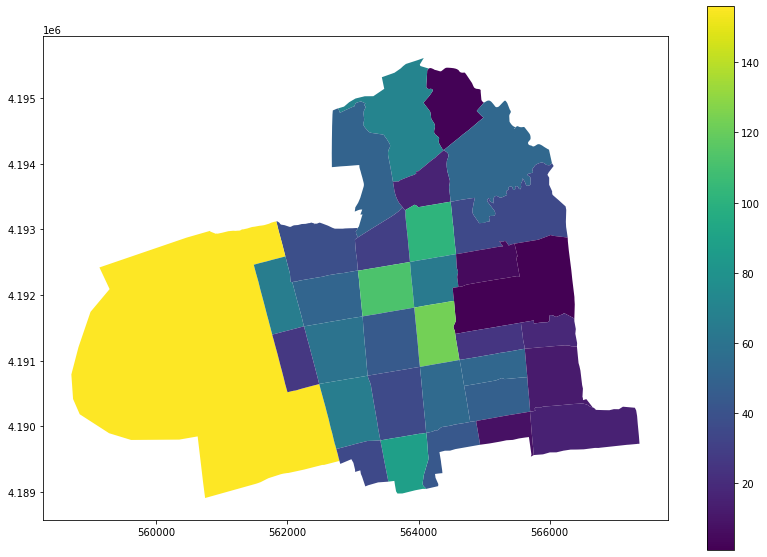

In [22]:
tracts2.plot(column='total_vandalism', figsize=(14,10), legend=True)

The default colormap is not very useful in this case. We can select a better colormap with the `cmap` param to  make our map more easily interpretable:

<AxesSubplot:>

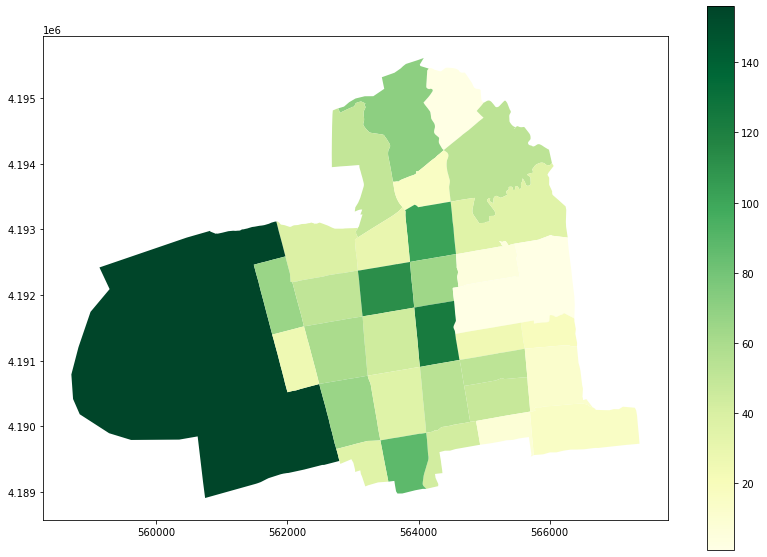

In [23]:
tracts2.plot(column='total_vandalism', cmap='YlGn', figsize=(14,10), legend=True)

Now might be a good opportunity to spend a few minutes experimenting with different colormaps. A good place to start would be here: http://matplotlib.org/users/colormaps.html

Which kinds of colormaps seem to work best for this data?

## 4.9. The Modifiable Areal Unit Problem (MAUP)

One common issue when working with geospatial data is known as the Modifiable Areal Unit Problem (MAUP)

<center><img src="https://mikejohnson51.github.io/spds/lec-img/15-maup.png" width=600></center>

This comes up quite frequently when working with choropleth maps, since polygons with larger areas tend to show up more prominently than might be appropriate. This happens for two reasons:
  1. Large areas occupy more visual space on the map
  2. Larger area == more observations 

We'll now investigate a few ways for dealing with these issues

### 4.9.1. Use Equal-Area Bins
Perhaps the simplest approach would have been to just leave the Census Tracts out of it for the purpose of data viz

In [24]:
# code won't work if we have any empty geometries
geovandalism_proj_blocks = geovandalism_proj_blocks[~geovandalism_proj_blocks.is_empty]

# plot
fig, ax = plt.subplots(figsize=(15,15))
g = blocks_proj.plot(color='none', edgecolor='k', linewidth=.25, ax=ax)
hb = ax.hexbin(geovandalism_proj_blocks['geometry'].x, geovandalism_proj_blocks['geometry'].y, gridsize=20, mincnt=1)
fig.colorbar(hb, shrink=.75)

AttributeError: module 'matplotlib' has no attribute 'subplots'

### 4.9.2. Normalize by Area

We often want to normalize our data by area to compute a density to offset this. Geopandas gives us access to an attribute of the geometry of polygons to get the areas, so this is fairly straightforward to do.

But first, check to see what units our projection is in so we can convert to a known area size, like square miles.

In [25]:
tracts2.crs

<Derived Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

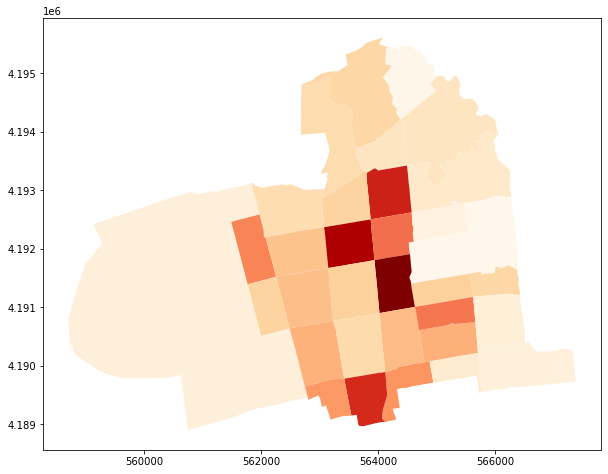

In [26]:
tracts2['area_sqmi'] = tracts2.area / 3.861e-7
tracts2['van_sqmi'] = tracts2['total_vandalism'] / tracts2['area_sqmi']
tracts2.plot(column='van_sqmi', cmap='OrRd', figsize=(10,8))

Ah, that looks much better!

### 4.9.3. Interpolate!

If we want to avoid aggregating the data into somewhat arbitrary geographies like census tracts, we can use 2D kernel density estimation to convert our discrete data points into a continuous surface:

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
g = blocks_proj.plot(color='none', edgecolor='k', linewidth=.25, ax=ax)
hb = sns.kdeplot(
    x=geovandalism_proj_blocks['geometry'].x, y=geovandalism_proj_blocks['geometry'].y,
    cmap='turbo', fill=True, alpha=0.6)

AttributeError: module 'matplotlib' has no attribute 'subplots'

The code in the next cell does essentially the same thing as the 2D KDE, but instead of estimating a continuous function it estimates a discrete 2D _histogram_ and applies a smoothing function. Code is adapted from [here](http://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434)

In [ ]:
from scipy import ndimage
import numpy as np

def heatmap(d, bins=(100,100), smoothing=1.3, cmap='turbo'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.gaussian_filter(logheatmap, smoothing, mode='nearest')
    blocks_proj.plot(color='none', edgecolor='white', linewidth=.5, alpha=.5, figsize=(15,10))

    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar(shrink=.75)
    plt.gca().invert_yaxis()
    plt.show()

heatmap(geovandalism_proj_blocks, bins=190, smoothing=5)

### Your Turn

To practice with Geopandas, experiment with the methods covered so far with data you are interested in working with on your project, or any other data you can find readily from an Open Data Portal like Berkeley, San Francisco, Oakland, New York, or others.

* Download a shapefile containing point data and attributes
* Create a GeoDataFrame
* Set its CRS
* Plot it with color coding of the points based on the values of an attribute
* Download a shapefile containing polygons and attributes
* Create a GeoDataFrame
* Plot a Choroplethic Map
* Change the coordinate procjetion on these from spherical to a projected coordinate system
* Do a spatial join of the point and polygon data
* Aggregate the joined data to summarize it


# 5. For next time
- Python installs: PySAL

# 6. Questions?

# Sources

- This notebook was heavily adapted from previous course material by [Prof. Paul Waddell](https://urbansim.com/people).